In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Used only selected columns 
df = pd.read_csv("../Data/selected_data/merged_data.csv", usecols=['Col1', 'batter', 'total_runs_delivery', 'balls_faced', 'winning_team', 'venue', 'toss_decision', 'toss_winner', 'batting_team', 'bowling_team', 'wickets_fallen'])

# Identify the boundaries of each inning
inning_boundaries_indices = df[df['Col1'] == 0].index.tolist()
inning_boundaries_indices.append(len(df))  # Add the last index

# Function to process each inning and extract features
def process_inning(df_inning):
    inning_features = {}
    inning_features['total_runs'] = df_inning['total_runs_delivery'].sum()
    inning_features['wickets_fallen'] = df_inning['wickets_fallen'].max()
    inning_features['strike_rate'] = df_inning['total_runs_delivery'].sum()*100/len(df_inning)
    inning_features['venue'] = df_inning['venue'].iloc[0]
    inning_features['toss_decision'] = df_inning['toss_decision'].iloc[0]
    inning_features['toss_winner'] = df_inning['toss_winner'].iloc[0]
    inning_features['batting_team'] = df_inning['batting_team'].iloc[0]
    inning_features['bowling_team'] = df_inning['bowling_team'].iloc[0]
    inning_features['winning_team'] = df_inning['winning_team'].iloc[0]
    return inning_features

# List to store inning features
inning_data = []

# Iterate through each inning using the boundaries
for i in range(len(inning_boundaries_indices) - 1):
    start_idx = inning_boundaries_indices[i]
    end_idx = inning_boundaries_indices[i + 1]
    df_inning = df.iloc[start_idx:end_idx]
    inning_features = process_inning(df_inning)
    inning_data.append(inning_features)

# Create DataFrame for inning data
inning_df = pd.DataFrame(inning_data)

# get all teams
teams = inning_df['batting_team'].unique()

# filter Data for each team in teams
for team in teams:
    team_df = inning_df[(inning_df['batting_team'] == team) | (inning_df['bowling_team'] == team)]
    # Encode categorical variables
    team_df = pd.get_dummies(team_df, columns=['venue', 'toss_decision', 'toss_winner', 'batting_team', 'bowling_team'])

    # Replace NaN values with appropriate defaults
    team_df.fillna(0, inplace=True)

    # Set the target team
    team_df['target'] = (team_df['winning_team'] == team).astype(int)

    # Split the data into features and target
    X = team_df.drop(columns=['winning_team', 'target'])
    y = team_df['target']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy for", team, ":", accuracy)

    # plot a graph to show the feature importance
    # only pick the top 10 features
    feature_importance = rf_classifier.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1]
    pos = np.arange(10) + .5
    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx][:10], align='center')
    plt.yticks(pos, X.columns[sorted_idx][:10])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Features for ' + team)
    plt.show()
    

    # Predict win probability for the target team for each inning
    win_probabilities = rf_classifier.predict_proba(X_test)[:, 1]
    print("Win Probability for", team, ":", win_probabilities)

    # Create a DataFrame with win probability and actual outcome
    result_df = pd.DataFrame({'Win Probability': win_probabilities, 'Actual Outcome': y_test})

    # Plot the graph
    plt.figure(figsize=(12, 6))
    plt.scatter(result_df[result_df['Actual Outcome'] == 0].index, result_df[result_df['Actual Outcome'] == 0]['Win Probability'], color='red', label='Actual Outcome: 0')
    plt.scatter(result_df[result_df['Actual Outcome'] == 1].index, result_df[result_df['Actual Outcome'] == 1]['Win Probability'], color='green', label='Actual Outcome: 1')
    plt.xlabel('Inning')
    plt.ylabel('Win Probability')
    plt.title('Win Probability vs Actual Outcome for ' + team)
    plt.legend()
    plt.show()

Accuracy: 0.9236842105263158
Win Probability for Sri Lanka: [0.32 0.   0.   0.06 0.03 0.01 0.02 0.   0.48 0.11 0.01 0.01 0.12 0.
 0.01 0.   0.21 0.   0.   0.61 0.16 0.01 0.   0.01 0.   0.   0.01 0.
 0.66 0.04 0.06 0.   0.   0.03 0.   0.   0.   0.03 0.1  0.   0.   0.
 0.   0.04 0.55 0.46 0.   0.04 0.   0.   0.01 0.17 0.18 0.   0.02 0.02
 0.09 0.04 0.07 0.   0.11 0.   0.   0.   0.   0.   0.01 0.   0.   0.01
 0.   0.   0.   0.01 0.36 0.   0.16 0.01 0.39 0.   0.02 0.01 0.   0.01
 0.   0.02 0.4  0.   0.02 0.   0.   0.   0.   0.6  0.03 0.   0.01 0.
 0.75 0.   0.   0.6  0.23 0.01 0.02 0.02 0.   0.01 0.04 0.01 0.03 0.09
 0.01 0.   0.01 0.   0.01 0.23 0.59 0.21 0.1  0.01 0.18 0.4  0.02 0.
 0.1  0.   0.5  0.02 0.25 0.   0.   0.01 0.01 0.   0.01 0.01 0.   0.
 0.01 0.   0.   0.   0.44 0.21 0.   0.03 0.   0.23 0.01 0.   0.08 0.
 0.   0.05 0.01 0.01 0.02 0.32 0.11 0.29 0.   0.04 0.03 0.   0.   0.
 0.   0.02 0.01 0.02 0.02 0.   0.   0.01 0.   0.06 0.02 0.01 0.   0.06
 0.01 0.   0.07 0.   0.   0.52 0.

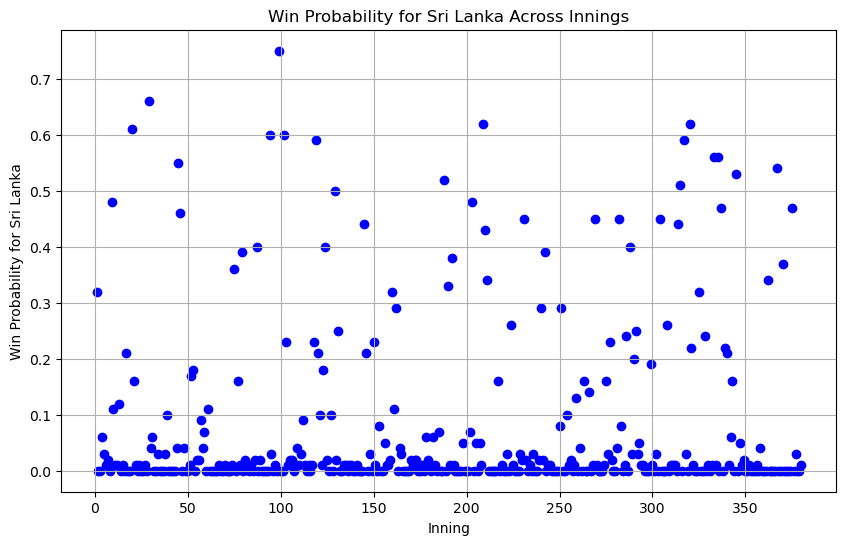

In [3]:
import matplotlib.pyplot as plt

# Plot win probabilities for Sri Lanka across innings
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(win_probabilities) + 1), win_probabilities, color='blue')
plt.xlabel('Inning')
plt.ylabel('Win Probability for Sri Lanka')
plt.title('Win Probability for Sri Lanka Across Innings')
plt.grid(True)
plt.show()


In [5]:
# Select numeric columns for correlation calculation
numeric_columns = inning_df.select_dtypes(include=['number'])

# Calculate Pearson correlation coefficients
correlation_matrix = numeric_columns.corr()

# Display correlations with the target variable (winning team)
winning_team_correlation = correlation_matrix['target'].drop('target')  # Drop the target variable itself
print("Correlation with Winning Team:")
print(winning_team_correlation)


Correlation with Winning Team:
total_runs        0.002165
wickets_fallen    0.049430
overs             0.049430
Name: target, dtype: float64
